In [30]:
import numpy as np
import matplotlib.pyplot as plt
import iiiraven2 as ir2
from chainconsumer import ChainConsumer
import get_pkbkmst
import get_likelihood

from sklearn.covariance import LedoitWolf

## Setup

In [2]:
# Which method to use
method = 'mst'
# How many multiples of the MST should we use
multiples = 1

Getting Fiducial : |####################| 100% 


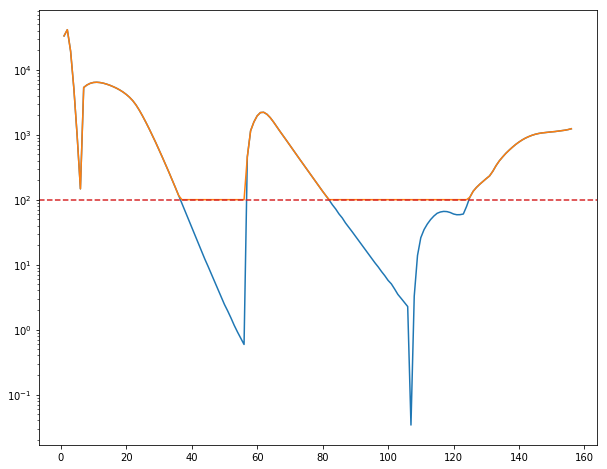

In [3]:
# Lets figure out basic things that we need to know.

which_method = 'mst'
condition_mst = [0, 1]
usefull = True
include_mult = True

fid_data_ = get_pkbkmst.get_fiducial(which_method, condition_mst, usefull=usefull,
                                    include_mult=include_mult, multiples=multiples)
fid_mean = np.mean(fid_data_, axis=0)
fid_mean2 = np.copy(fid_mean)

x = np.arange(1., len(fid_mean)+1., 1.)

count_min = 100.

plt.figure(figsize=(10, 8))
plt.plot(x, fid_mean)

condition_mst = np.where(fid_mean > count_min)[0]
condition_not_mst = np.where(fid_mean <= count_min)[0]

# check this works

fid_mean2[condition_not_mst] = count_min

plt.plot(x, fid_mean2)
plt.axhline(count_min, color='C3', linestyle='--')
plt.yscale('log')
plt.show()


## Get Data

In [4]:
which_method = method

# Get Parameters

as_grid, om_grid, mv_grid, s8_grid = get_pkbkmst.get_grid_params()
as_mock, om_mock, mv_mock, s8_mock = get_pkbkmst.get_mock_params()
as_fid, om_fid, mv_fid, s8_fid = get_pkbkmst.get_fiducial_params()

as_min, as_max = 1., 3.5
om_min, om_max = 0.2, 0.5
mv_min, mv_max = 0., 1.
s8_min, s8_max = s8_grid.min(), s8_grid.max()

grid_data = get_pkbkmst.get_grid(which_method, condition_mst, usefull=usefull,
                                 include_mult=include_mult, multiples=multiples)
mock_data = get_pkbkmst.get_mock(which_method, condition_mst, usefull=usefull,
                                 include_mult=include_mult, multiples=multiples)
fid_data = get_pkbkmst.get_fiducial(which_method, condition_mst, usefull=usefull,
                                    include_mult=include_mult, multiples=multiples)

fid_mean = np.mean(fid_data, axis=0)
fid_std = np.std(fid_data, axis=0)

Getting Grid1 : |####################| 100% 
Getting Grid2 : |####################| 100% 
Getting Grid3 : |####################| 100% 
Getting Grid4 : |####################| 100% 
Getting Grid5 : |####################| 100% 
Getting Grid6 : |####################| 100% 
Getting Grid7 : |####################| 100% 
Getting Mock : |####################| 100% 
Getting Fiducial : |####################| 100% 


In [5]:
# Cut grid data to only the ones in this range.

as_min, as_max = 1., 3.5
om_min, om_max = 0.2, 0.5
mv_min, mv_max = 0., 0.5
s8_min, s8_max = s8_grid.min(), s8_grid.max()

condition = np.where((as_grid >= as_min) & (as_grid <= as_max) &
                     (om_grid >= om_min) & (om_grid <= om_max) &
                     (mv_grid >= mv_min) & (mv_grid <= mv_max))[0]

print 'Number of usable Grid Sims = ', len(condition)

as_grid = as_grid[condition]
om_grid = om_grid[condition]
mv_grid = mv_grid[condition]
s8_grid = s8_grid[condition]
grid_data = grid_data[condition]

Number of usable Grid Sims =  670


## Calculate Covariance and Precision Matrix

In [31]:
cov = np.cov(fid_data.T)
inv_cov = np.linalg.inv(cov)

lw = LedoitWolf(store_precision=True, assume_centered=False)
lw.fit(fid_data)
lw_cov_ = lw.covariance_
lw_prec_ = lw.precision_
cov, inv_cov = lw_cov_, lw_prec_

## Calculate Log-Likelihood

In [32]:
ln_probs = []

N, M = 1000., 3.
precision = inv_cov

for i in range(0, len(mock_data)):
    data = mock_data[i]
    ln_prob = []
    for j in range(0, len(grid_data)):
        model = grid_data[j]
        ln_prob_val = get_likelihood.get_lnP(data, model, precision, N, M)
        ln_prob.append(ln_prob_val)
    ln_probs.append(np.array(ln_prob))
ln_probs = np.array(ln_probs)

## Calculate Log-Likelihood Uncertainties

In [33]:
ln_probs_fid = []

N, M = 1000., 3.
precision = inv_cov

for i in range(0, len(fid_data)):
    data = fid_data[i]
    ln_prob = []
    for j in range(0, len(grid_data)):
        model = grid_data[j]
        ln_prob_val = get_likelihood.get_lnP(data, model, precision, N, M)
        ln_prob.append(ln_prob_val)
    ln_probs_fid.append(np.array(ln_prob))
ln_probs_fid = np.array(ln_probs_fid)

In [34]:
ln_probs_fid_mean = np.mean(ln_probs_fid, axis=0)
ln_probs_fid_std = np.std(ln_probs_fid, axis=0)

In [35]:
fid_mu = []
count = 3
for i in range(0, len(fid_data)):
    _d = np.copy(fid_data[i])
    if count == 3:
        if i != 0:
            fid_mu.append(d/3.)
        count = 1
        d = _d
    else:
        count += 1
        d = d + _d

fid_mu = np.array(fid_mu)

ln_prob_fid_bias = []

N, M = 1000., 3.
precision = inv_cov

data = fid_data[0]

for i in range(0, len(fid_mu)):
    model = fid_mu[i]
    ln_prob_val = get_likelihood.get_lnP(data, model, precision, N, M)
    ln_prob_fid_bias.append(ln_prob_val)
ln_prob_fid_bias = np.array(ln_prob_fid_bias)

ln_prob_fid_bias_std = np.std(ln_prob_fid_bias)

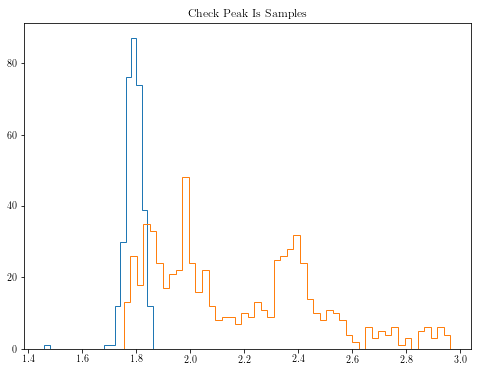

In [36]:
plt.figure(figsize=(8, 6))
plt.title('Check Peak Is Samples')
plt.hist(np.log10(abs(ln_prob_fid_bias)), 20, histtype='step',
         label='Grid Log Likelihood')
plt.hist(np.log10(abs(np.mean(ln_probs, axis=0))), 50, histtype='step',
         label='Fiducial Log Likelihood')
plt.show()

## Tune Interpolation

number of sims to calculate chi2 =  192
chi2 =  1.17887478141


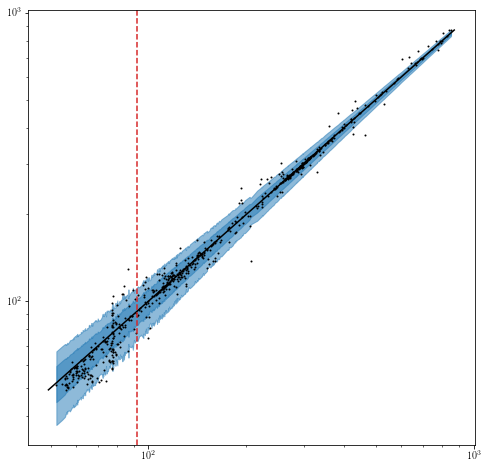

In [64]:
as_g = (as_grid-as_min)/(as_max-as_min)
om_g = (om_grid-om_min)/(om_max-om_min)
mv_g = (mv_grid-mv_min)/(mv_max-mv_min)

ln_prob = ln_probs_fid_mean

ln_gaussian_est = []
sig = 0.035
#pk: sig = 0.06

for i in range(0, len(as_g)):
    r = np.sqrt((as_g - as_g[i])**2. + (om_g - om_g[i])**2. + (mv_g - mv_g[i])**2.)
    weight = np.exp(-0.5*(r**2.)/sig**2.)
    ln_gaussian_est.append(np.sum(weight*ln_prob)/np.sum(weight))
    
ln_gaussian_est = np.array(ln_gaussian_est)

ln_gaussian_cut = ln_gaussian_est.max() - 0.05*(ln_gaussian_est.max() - ln_gaussian_est.min())

condition = np.where(ln_gaussian_est > ln_gaussian_cut)[0]

print 'number of sims to calculate chi2 = ', len(condition)

chi2 = np.sum(((ln_gaussian_est[condition] - ln_prob[condition])**2.)/(ln_probs_fid_std[condition]**2. + ln_prob_fid_bias_std**2.))/float(len(ln_gaussian_est[condition]))

print 'chi2 = ', chi2

sorted_ln = np.array(sorted(zip(abs(ln_gaussian_est), abs(ln_prob), np.sqrt(ln_probs_fid_std**2. + ln_prob_fid_bias_std**2.))))
x = sorted_ln[:, 0]
y = sorted_ln[:, 1]
xerr = sorted_ln[:, 2]

plt.figure(figsize=(8, 8))
xx = np.linspace(abs(ln_prob).min(), abs(ln_prob).max(), 10000)
plt.plot(xx, xx, color='k')
plt.fill_between(x, x-2.*xerr, x+2.*xerr, alpha=0.5, color='C0')
plt.fill_between(x, x-xerr, x+xerr, alpha=0.5, color='C0')
plt.scatter(abs(ln_gaussian_est), abs(ln_prob), s=1, color='k')
plt.axvline(abs(ln_gaussian_cut), color='C3', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Interpolate Log Likelihood in Box

In [65]:
ngrid = 50
as_box, om_box, mv_box = np.mgrid[as_min:as_max:ngrid*1j, om_min:om_max:ngrid*1j, mv_min:mv_max:ngrid*1j]

as_box = as_box.flatten()
om_box = om_box.flatten()
mv_box = mv_box.flatten()

as_b = (as_box-as_min)/(as_max-as_min)
om_b = (om_box-om_min)/(om_max-om_min) 
mv_b = (mv_box-mv_min)/(mv_max-mv_min)

In [66]:
r_threshold = 0.1

ln_prior = []

for i in range(0, len(as_box)):
    val = get_likelihood.get_nearest(as_box.flatten()[i], om_box.flatten()[i], mv_box.flatten()[i],
                                    as_min, as_max, om_min, om_max, mv_min, mv_max,
                                    as_grid, om_grid, mv_grid, r_threshold)
    if val != 0.:
        ln_prior.append(0.)
    else:
        ln_prior.append(1.)
    ir2.progress_bar(i, len(as_box))

ln_prior = np.array(ln_prior)

|####################| 100% 


In [52]:
truth = [2.13, 0.3175, 0.06]
c = ChainConsumer()
c.add_chain([as_box, om_box, mv_box], parameters = ['as', 'om', 'mv'], 
            weights=ln_prior, grid=True)
c.configure(kde=[1.], sigmas = [1, 2] )
fig = c.plotter.plot(figsize = (7,6), truth=truth)
plt.savefig('plots/prior.pdf')

In [67]:
ln_boxs = []
post_boxs = []

for j in range(0, len(ln_probs)):
    
    ln_box = []
    post_box = []
    
    for i in range(0, len(as_b)):

        r = np.sqrt((as_g - as_b[i])**2. + (om_g - om_b[i])**2. + (mv_g - mv_b[i])**2.)
        weight = np.exp(-0.5*(r**2.)/sig**2.)
        ln_box.append(np.sum(weight*ln_probs[j])/np.sum(weight))
        post_box.append(np.sum(weight*np.exp(ln_probs[j] - ln_probs[j].max()))/np.sum(weight))
        
        ir2.progress_bar(i, len(as_b), explanation='Mock ' + str(j+1))
    
    ln_boxs.append(np.array(ln_box))
    post_boxs.append(np.array(post_box))

ln_boxs = np.array(ln_boxs)
post_boxs = np.array(post_boxs)

Mock 1 : |####################| 100% 
Mock 2 : |####################| 100% 
Mock 3 : |####################| 100% 
Mock 4 : |####################| 100% 
Mock 5 : |####################| 100% 
Mock 6 : |####################| 100% 
Mock 7 : |####################| 100% 
Mock 8 : |####################| 100% 
Mock 9 : |####################| 100% 
Mock 10 : |####################| 100% 


In [68]:
# Set extrapolated regions to minimum log likelihood

condition = np.where(ln_prior == 0.)

for i in range(0, len(ln_boxs)):
    ln_boxs[i][condition] = ln_probs[i].min()
    post_boxs[i][condition] = post_boxs[i].min()


## Mean Contours

In [69]:
ln_box_mean = np.mean(ln_boxs, axis=0)
post_box_mean = np.mean(post_boxs, axis=0)

truth = [2.13, 0.3175, 0.06]
c = ChainConsumer()
c.add_chain([as_box, om_box, mv_box],
            parameters = ['as', 'om', 'mv'], 
            weights=post_box_mean, grid=True)
c.configure(kde = [2.5], sigmas = [1,2] )
fig = c.plotter.plot(figsize = (7,6), truth=truth)
plt.savefig('plots/' + method + '_mean_exp.pdf')

"""
truth = [2.13, 0.3175, 0.06]
c = ChainConsumer()
c.add_chain([as_box, om_box, mv_box],
            parameters = ['as', 'om', 'mv'], 
            weights=np.exp(ln_box_mean-ln_box_mean.max()), grid=True)
c.configure(kde = [2.5], sigmas = [1,2] )
fig = c.plotter.plot(figsize = (7,6), truth=truth)
plt.savefig('plots/' + method + '_mean.pdf')
"""

"\ntruth = [2.13, 0.3175, 0.06]\nc = ChainConsumer()\nc.add_chain([as_box, om_box, mv_box],\n            parameters = ['as', 'om', 'mv'], \n            weights=np.exp(ln_box_mean-ln_box_mean.max()), grid=True)\nc.configure(kde = [2.5], sigmas = [1,2] )\nfig = c.plotter.plot(figsize = (7,6), truth=truth)\nplt.savefig('plots/' + method + '_mean.pdf')\n"

## Individual Contours

In [70]:
truth = [2.13, 0.3175, 0.06]
c = ChainConsumer()
for i in range(0, len(ln_boxs)):
    c.add_chain([as_box, om_box, mv_box],
                parameters = ['as', 'om', 'mv'], 
                weights=post_boxs[i], grid=True)
c.configure(kde = 2.5*np.ones(len(post_boxs)), sigmas = [1,2] )
fig = c.plotter.plot(figsize = (7,6), truth=truth)
plt.savefig('plots/' + method + '_exp.pdf')
"""
truth = [2.13, 0.3175, 0.06]
c = ChainConsumer()
for i in range(0, len(ln_boxs)):
    c.add_chain([as_box, om_box, mv_box],
                parameters = ['as', 'om', 'mv'], 
                weights=np.exp(ln_boxs[i]-ln_boxs[i].max()), grid=True)
c.configure(kde = 2.5*np.ones(len(ln_boxs)), sigmas = [1,2] )
fig = c.plotter.plot(figsize = (7,6), truth=truth)
plt.savefig('plots/' + method + '.pdf')
"""

"\ntruth = [2.13, 0.3175, 0.06]\nc = ChainConsumer()\nfor i in range(0, len(ln_boxs)):\n    c.add_chain([as_box, om_box, mv_box],\n                parameters = ['as', 'om', 'mv'], \n                weights=np.exp(ln_boxs[i]-ln_boxs[i].max()), grid=True)\nc.configure(kde = 2.5*np.ones(len(ln_boxs)), sigmas = [1,2] )\nfig = c.plotter.plot(figsize = (7,6), truth=truth)\nplt.savefig('plots/' + method + '.pdf')\n"

In [50]:
np.savez('data/'+method+'_likelihood.npz', 
         as_box=as_box, om_box=om_box, mv_box=mv_box, ln_boxs=ln_boxs)

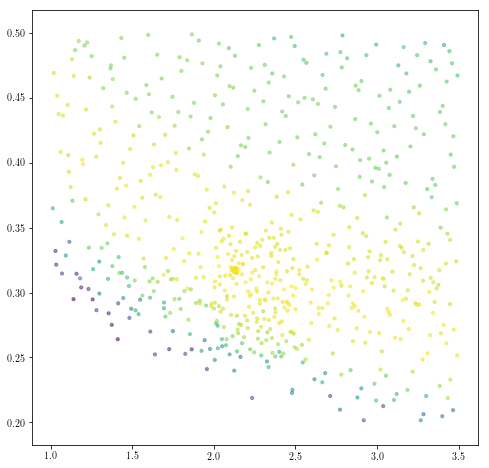

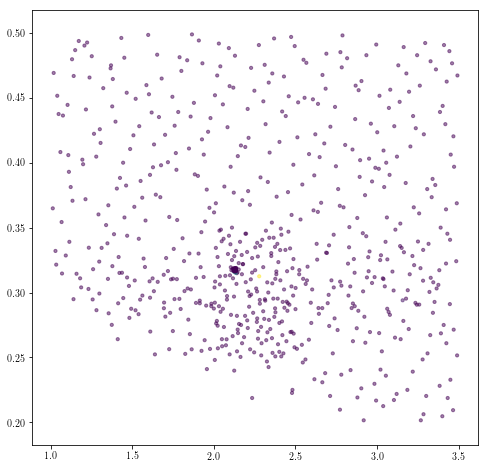

2.27777777778 0.3125 0.04


In [48]:
i = 0

plt.figure(figsize=(8, 8))
plt.scatter(as_grid, om_grid, c=ln_probs[i]-ln_probs[i].max(), s=10, alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(as_grid, om_grid, c=np.exp(ln_probs[i]-ln_probs[i].max()), s=10, alpha=0.5)
plt.show()

print as_grid[np.argmax(ln_probs[i])], om_grid[np.argmax(ln_probs[i])], mv_grid[np.argmax(ln_probs[i])]